<a href="https://colab.research.google.com/github/ConstDahoud/simple_dnn/blob/main/02_spiral_classification_with_simple_dnn_using_gradient_tape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spiral classification with simple dnn using gradient tape



## Setup

In [1]:
import sys
assert sys.version_info >= (3,6)

import tensorflow as tf
assert tf.__version__ >= "2.0"

import numpy as np
import matplotlib.pyplot as plt

## Define spiral data generation function

In [2]:
def generate_spiral_dataset(num_class, num_data, num_dim=2):    # 3, 200, 2
    input_data = np.zeros((num_class*num_data, num_dim))    # data matrix(each row: single example) 
    output_data = np.zeros((num_class*num_data), dtype=np.uint8)    # labels

    for class_index in range(num_class):
        indices = range(num_data*class_index, num_data*(class_index+1))
        radiuses = np.linspace(0.0, 1, num_data)    # a range of the radiuses: [0, 1]
        thetas = np.linspace(4*class_index, 4*(class_index+1), num_data)    # theta = 4
        noise = np.random.randn(num_data)*0.2
        thetas += noise
        input_data[indices] = np.column_stack((radiuses*np.sin(thetas), radiuses*np.cos(thetas)))    # shape: (num_class*num_data, num_dim)
        output_data[indices] = class_index    # shape: (num_class*num_data, )

    return input_data, output_data

## Generate train data and test data

In [3]:
X_train, y_train = generate_spiral_dataset(num_class=3, num_data=200, num_dim=2)
X_test, y_test = generate_spiral_dataset(num_class=3, num_data=200, num_dim=2)

## Let visualize the data

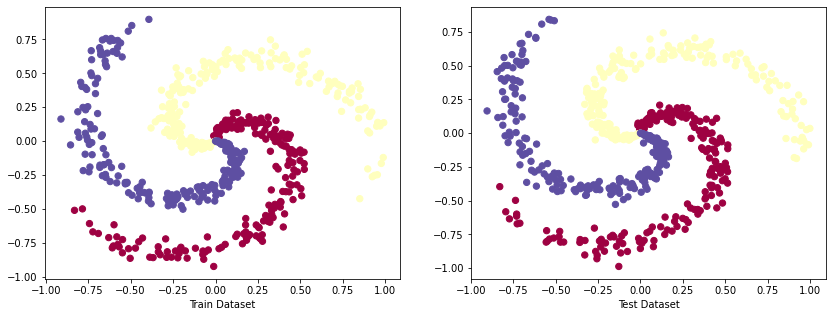

In [4]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Train Dataset")
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Test Dataset")
plt.show()

## Define the model

In [5]:
class Simple_dnn(tf.Module):
    def __init__(self):
        # create weight and bias matrixes
        initializer = tf.initializers.GlorotUniform()
        W0 = tf.Variable(initializer(shape=[2, 20]), dtype=tf.float32, name='W0')
        W1 = tf.Variable(initializer(shape=[20, 20]), dtype=tf.float32, name='W1')
        W2 = tf.Variable(initializer(shape=[20, 3]), dtype=tf.float32, name='W2')

        b0 = tf.Variable(tf.zeros(shape=[20]), dtype=tf.float32, name='b0')
        b1 = tf.Variable(tf.zeros(shape=[20]), dtype=tf.float32, name='b1')
        b2 = tf.Variable(tf.zeros(shape=[3]), dtype=tf.float32, name='b2')

        self.weights = [W0, W1, W2]
        self.biases = [b0, b1, b2]
        self.activations = [tf.nn.relu, tf.nn.relu, tf.nn.softmax]

    def __call__(self, x):
        layer = x
        for W, b, activation in zip(self.weights, self.biases, self.activations):
            layer = activation(tf.matmul(layer, W) + b)

        output_pred = layer
        
        return output_pred

## Define random batch function to get a random subset of the training data

In [6]:
def random_batch(inputs, outputs, batch_size=32):
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = tf.Variable(inputs[indices], dtype=tf.float32, name='input')
    output_batch = tf.Variable(outputs[indices], dtype=tf.uint8, name='output')
    return input_batch, output_batch

## Train the model

In [7]:
simple_dnn = Simple_dnn()
optimizer = tf.optimizers.Adam()    # create optimizer

# run training
batch_size = 32
for training_step in range(10001):
    input_batch, output_batch = random_batch(X_train, y_train, batch_size=batch_size)
    output_batch = tf.one_hot(output_batch, 3)

    with tf.GradientTape() as tape:
        # forward pass
        output_pred = simple_dnn(input_batch)
        # compute the loss
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=output_batch, logits=output_pred)
        loss = tf.reduce_mean(loss)
        # compute gradients(Back propagation)
        grads = tape.gradient(loss, simple_dnn.trainable_variables)
        # perform a gradient descent step
        optimizer.apply_gradients(zip(grads, simple_dnn.trainable_variables))

    if training_step % 1000 == 0:
        print(f'training step: {training_step:04d}, loss: {loss.numpy():.3f}')

training step: 0000, loss: 1.111
training step: 1000, loss: 0.686
training step: 2000, loss: 0.603
training step: 3000, loss: 0.587
training step: 4000, loss: 0.572
training step: 5000, loss: 0.567
training step: 6000, loss: 0.552
training step: 7000, loss: 0.553
training step: 8000, loss: 0.560
training step: 9000, loss: 0.552
training step: 10000, loss: 0.551


## Test the model

In [8]:
test_input = tf.Variable(X_test, dtype=tf.float32, name='input')
test_output = tf.Variable(y_test, dtype=tf.float32, name='output')

test_output_pred = simple_dnn(test_input)
test_output_pred = tf.nn.softmax(test_output_pred, axis=-1)

## Let visualize the result

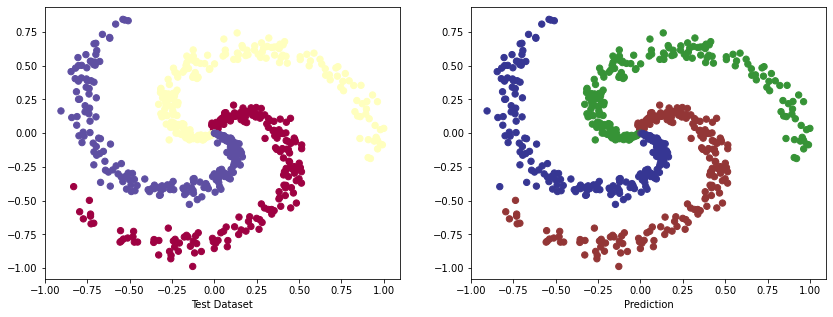

In [9]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap=plt.cm.Spectral)
plt.xlabel("Test Dataset")
plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=test_output_pred.numpy(), s=40, cmap=plt.cm.Spectral)
plt.xlabel("Prediction")
plt.show()